# Introduction

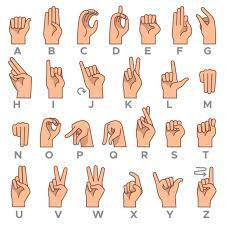

This notebook is created for [Kaggle's Isolated Sign Language Recognition Competition](https://www.kaggle.com/competitions/asl-signs/overview)

It is a compilation of various resources which have been modified to create this notebook. Please acknowledge and give upvotes to these resources if you find them useful:

- The notebook [LSTM Baseline for Starters - Sign Language](https://www.kaggle.com/code/jvthunder/lstm-baseline-for-starters-sign-language) was used as the major reference..

- The landmark data visualization from [Sign Language EDA & Visualization](https://www.kaggle.com/code/mayukh18/sign-language-eda-visualization) was also incorporated..

- The preprocessed tensorflow dataset from [tfdataset-of-google-isl-recognition-data](https://www.kaggle.com/datasets/aapokossi/saved-tfdataset-of-google-isl-recognition-data) was used.

- The model was trained based on the notebook [Submission for variable length time-series model](https://www.kaggle.com/code/aapokossi/submission-for-variable-length-time-series-model). The layers and epoch were tweaked for accuracy improvement.

This notebook is designed with beginners in mind, and includes detailed descriptions to aid in learning the model.


<a id="contents"></a>
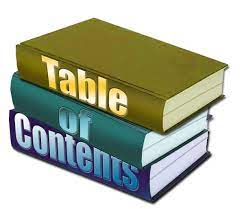
1. [Importng Libraries and Setting File Directories](#section-one)
2. [Data Visualization](#section-two)
3. [Loading Data](#section-three)
4. [Model Training](#section-four)
5. [Model Submission](#section-five)

<a id="section-one"></a>
# Import Libraries and Set File Directories

These lines import the necessary libraries for data analysis, visualization, and machine learning. 

* `pandas`: library for data manipulation and analysis.
* `numpy`: library for numerical computing.
* `matplotlib.pyplot`: library for data visualization.
* `tensorflow`: open-source library for machine learning and deep learning.
* `layers` and `optimizers` sub-modules from the `tensorflow.keras` package for specifying and optimizing neural networks.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, optimizers

These codes are setting the file directories for a dataset of American Sign Language signs. 

- `LANDMARK_FILES_DIR` is the directory path where the landmark files for the training set of ASL images are stored. The variable is set to the path "/kaggle/input/asl-signs/train_landmark_files".

- `TRAIN_FILE` is the directory path where the training dataset CSV file is stored. The variable is set to the path "/kaggle/input/asl-signs/train.csv".

These variables will be used later in the code to access the required files and load the data for the training of the machine learning model.

In [2]:
# set files directories
LANDMARK_FILES_DIR = "/kaggle/input/asl-signs/train_landmark_files"
TRAIN_FILE = "/kaggle/input/asl-signs/train.csv"

<a id="section-two"></a>
# Data Visualization

In this competition, we are given [parquet](https://towardsdatascience.com/demystifying-the-parquet-file-format-13adb0206705) files. The command `read_parquet` is employed to read it. 

In [3]:
# read the data, the type of the data
sample = pd.read_parquet("/kaggle/input/asl-signs/train_landmark_files/16069/100015657.parquet")
sample.head()

,frame,row_id,type,landmark_index,x,y,z
0,103,103-face-0,face,0,0.437886,0.437599,-0.051134
1,103,103-face-1,face,1,0.443258,0.392901,-0.067054
2,103,103-face-2,face,2,0.443997,0.409998,-0.042990
3,103,103-face-3,face,3,0.435256,0.362771,-0.039492
4,103,103-face-4,face,4,0.443780,0.381762,-0.068013


Each parquet file represents facial, hand, and pose landmark data from multiple frames generated by a video that corresponds to one particular sign. Each row corresponds to a specific landmark identified on a type like face, with the following information provided:

- **Frame:** the frame number in which the landmark was detected
- **Row ID:** a unique identifier for the landmark in that frame which is coded as Frame-Type-Landmark Index.
- **Type:** specifies the type of landmark like Face, Left hand, Right hand or Pose.
- **Landmark Index:** a numeric index as per mediapipe indexing. For eg. The landmark model in MediaPipe Pose predicts the location of 33 pose landmarks (see below)
- **X, Y, Z:** the coordinates of the landmark in three-dimensional space (where X is the horizontal axis, Y is the vertical axis, and Z represents depth).

In this specific example, the data relates to the 103rd frame of a video and includes information for five landmarks labeled "103-face-0" through "103-face-4". The X, Y, and Z values for each landmark provide information about their position in space relative to the camera.

# Visualizing things is always enjoyable, isn't it? 
However, since the data we are dealing with pertains to sequential hand movements, it may not be easily perceptible through tabular presentation alone. Therefore, it would be preferable to represent the movements using matplotlib through plotting. But before that, let's take a look at all different landmarks that are available in the dataset according to mediapipe's definitions to better understand the data in any particular frame.

**Landmark Models
MediaPipe Holistic utilizes the pose, face and hand landmark models in MediaPipe Pose, MediaPipe Face Mesh and MediaPipe Hands respectively to generate a total of 543 landmarks (33 pose landmarks, 468 face landmarks, and 21 hand landmarks per hand).**

- **Face Landmarks = 468**

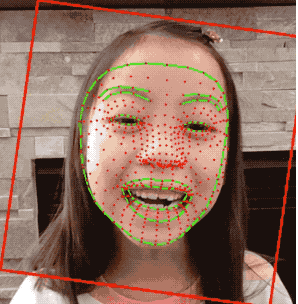

- **Pose Landmarks = 33**

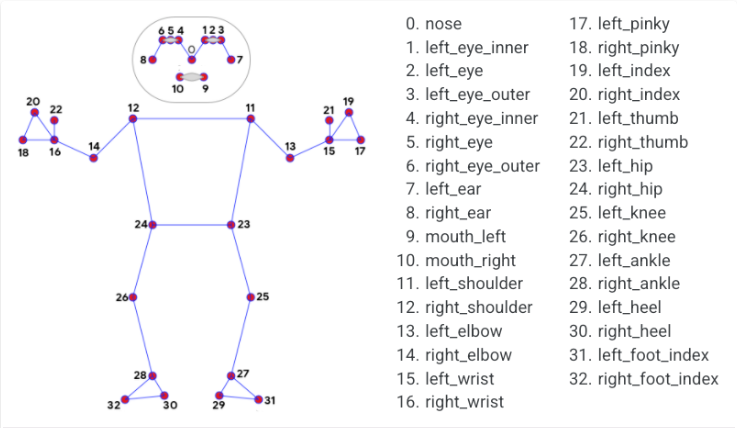

- **Hand Landmarks = 21**

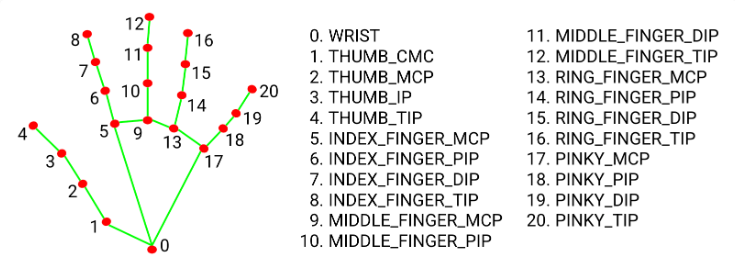

Total landmarks `= 468 + 33 + 21(left) + 21(right) = 543`

# Plotting Hand from tabular data
The below codes are used for plotting a sequence of frames for the left hand in a 2D coordinate system. 

Firstly, the left hand and right hand points are separately picked from the given sample using boolean indexing. Then, a list of edges is created that represent the hand edges according to **MediaPipe indexing**. 

The `plot_frame` function takes in a dataframe, a frame ID, and an axis object as input parameters. It sorts the dataframe based on the landmark_index column and extracts the x and y coordinates for each landmark. Then, the scatter plot is used to plot the landmarks on the axis object, giving each landmark a number label using the `ax.text` function. The hand edges are then plotted using a line plot by retrieving the coordinates for each edge. Lastly, axis ticks and labels are hidden using the `set_xticks`, `set_xticklabels`, `set_yticks`, and `set_yticklabels` functions.

The `plot_frame_seq` function generates a sequence of frames by taking a dataframe, a frame range, the number of frames to produce as inputs. It produces a subplot for each frame using the `plt.subplots` function and calls the `plot_frame` function to plot each frame. Overall, the function plots a sequence of frames for one hand using a similar plotting method as the `plot_frame` function.

Finally, the `plot_frame_seq` function is called with the `sample_left_hand` dataframe, a range of frames, and the number of frames to show. This plots a sequence of 10 frames for the left hand based on the given sample data.

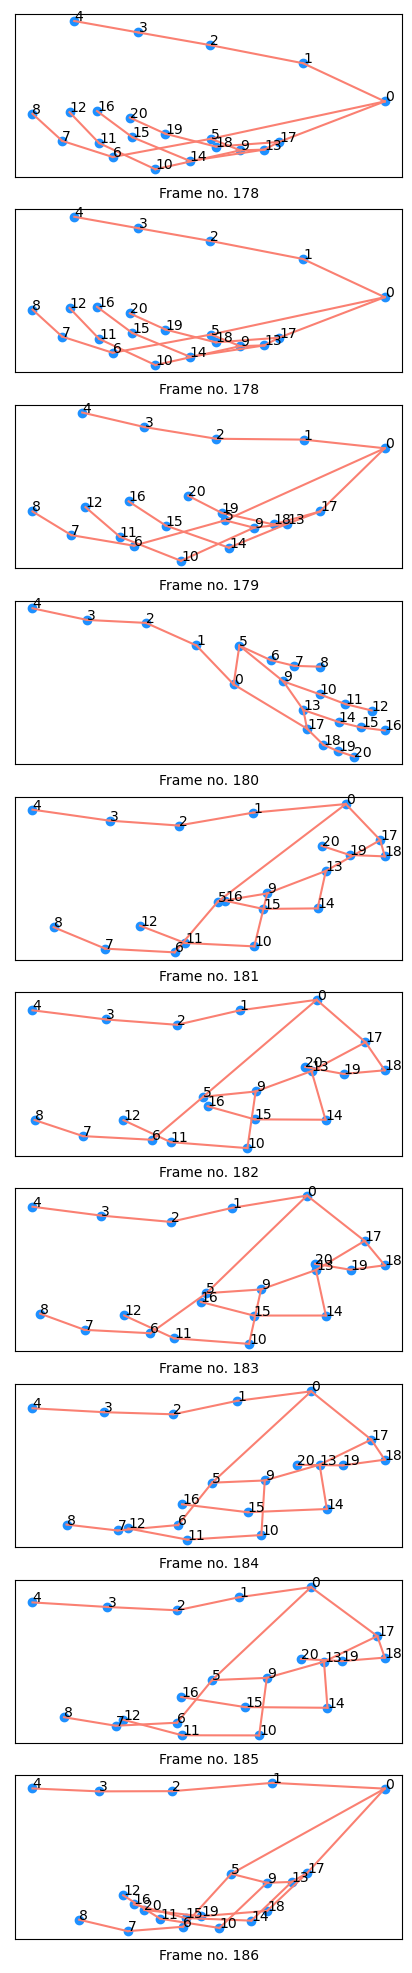

In [4]:
# pick the left hand and right hand points
sample_left_hand = sample[sample.type == "left_hand"]
sample_right_hand = sample[sample.type == "right_hand"]

# edges that represents the hand edges
edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]

# plotting a single frame into matplotlib
def plot_frame(df, frame_id, ax):
    df = df[df.frame == frame_id].sort_values(['landmark_index'])
    x = list(df.x)
    y = list(df.y)
    
    # plotting the points
    ax.scatter(df.x, df.y, color='dodgerblue')
    for i in range(len(x)):
        ax.text(x[i], y[i], str(i))
    
    # plotting the edges that represents the hand
    for edge in edges:
        ax.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color='salmon')
        ax.set_xlabel(f"Frame no. {frame_id}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

# plotting the multiple frames
def plot_frame_seq(df, frame_range, n_frames):
    frames = np.linspace(frame_range[0],frame_range[1],n_frames, dtype = int, endpoint=True)
    fig, ax = plt.subplots(n_frames, 1, figsize=(5,25))
    for i in range(n_frames):
        plot_frame(df, frames[i], ax[i])
        
    plt.show()

plot_frame_seq(sample_left_hand, (178,186), 10)

<a id="section-three"></a>
# Loading Data
The section is defining and setting constant values that will be used in the script. 

- `LANDMARK_IDX`: a list of integers representing the index positions of important landmarks in the dataset.
- `DATA_PATH`: a string containing the path to the directory where the dataset files are stored.
- `DS_CARDINALITY`: an integer representing the total number of data samples in the dataset.
- `VAL_SIZE`: an integer representing the number of data samples to be used in the validation set.
- `N_SIGNS`: an integer representing the number of different sign gestures in the dataset.
- `ROWS_PER_FRAME`: an integer representing the number of rows in each data sample, which corresponds to the number of landmark points detected and tracked by the model.

In [5]:
# Set constants and pick important landmarks
LANDMARK_IDX = [0,9,11,13,14,17,117,118,119,199,346,347,348] + list(range(468,543))
#LANDMARK_IDX = list(range(0,543))
#LANDMARK_IDX = list(range(468,543))
DATA_PATH = "/kaggle/input/saved-tfdataset-of-google-isl-recognition-data/GoogleISLDatasetBatched"
DS_CARDINALITY = 185
VAL_SIZE  = 20
N_SIGNS = 250
ROWS_PER_FRAME = 543

**Preprocessed [tf.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) from [tfdataset-of-google-isl-recognition-data](https://www.kaggle.com/datasets/aapokossi/saved-tfdataset-of-google-isl-recognition-data) is being used.**

The code defines a function `preprocess` that takes in two arguments: a `ragged_batch` tensor and a `labels` tensor. The function first gathers the `LANDMARK_IDX` elements from the third axis of the `ragged_batch` tensor using the `tf.gather` function. Next, it uses the `tf.where` function to replace any NaN values in the `ragged_batch` tensor with zeros. Finally, the function concatenates the first three elements of the last axis in the `ragged_batch` tensor and returns the result along with the `labels` tensor.

The code then loads a dataset from `DATA_PATH`, applies the `preprocess` function to each element in the dataset using the `map` method, and separates it into validation and training sets. The validation set is taken from the beginning of the dataset using the `take` method and is cached and prefetched for efficient processing. The training set is skipped over the validation set using the `skip` method, then cached, shuffled, and prefetched for efficient processing as well.

In [6]:
def preprocess(ragged_batch, labels):
    ragged_batch = tf.gather(ragged_batch, LANDMARK_IDX, axis=2)
    ragged_batch = tf.where(tf.math.is_nan(ragged_batch), tf.zeros_like(ragged_batch), ragged_batch)
    return tf.concat([ragged_batch[...,i] for i in range(3)],-1), labels

dataset = tf.data.Dataset.load(DATA_PATH)
dataset = dataset.map(preprocess)
val_ds = dataset.take(VAL_SIZE).cache().prefetch(tf.data.AUTOTUNE)
train_ds = dataset.skip(VAL_SIZE).cache().shuffle(20).prefetch(tf.data.AUTOTUNE)

In [7]:
import numpy as np
val_elem = val_ds.take(2)

# Print the elements
for elem1 in val_elem:
    elem1 = np.array(elem1, dtype=object)
print(elem1[0][5].shape)
print(elem1[1].shape)
print(elem1[0].shape)
elem1.shape

(115, 264)
(512, 1)
(512, None, 264)


(2,)

In [8]:
import numpy as np
first_elem = train_ds.take(2)

# Print the elements
for elem in first_elem:
    elem = np.array(elem, dtype=object)
    #print(elem)

In [9]:
#elem = np.array(first_elem[0], dtype=object)
print(elem[0][5])
print(elem[1][5])

tf.Tensor(
[[0.3465372  0.3251237  0.3471654  ... 0.         0.         0.        ]
 [0.34037682 0.32135263 0.3411506  ... 0.         0.         0.        ]
 [0.3385566  0.32032362 0.33923206 ... 0.         0.         0.        ]
 ...
 [0.3470939  0.3272371  0.34782666 ... 0.         0.         0.        ]
 [0.34609216 0.32730418 0.34667176 ... 0.         0.         0.        ]
 [0.34585953 0.32672983 0.34658086 ... 0.         0.         0.        ]], shape=(10, 264), dtype=float32)
tf.Tensor([35], shape=(1,), dtype=int64)


In [10]:
print(elem[0].shape)

(512, None, 264)


In [11]:
print(elem[1].shape)

(512, 1)


In [12]:
print(elem[0][5][0])

tf.Tensor(
[ 3.46537203e-01  3.25123698e-01  3.47165406e-01  3.47740173e-01
  3.51291269e-01  3.54167163e-01  2.33261406e-01  2.48023868e-01
  2.69697726e-01  3.50199014e-01  4.41138595e-01  4.26450968e-01
  4.03170139e-01  7.03496933e-01  6.48144603e-01  6.15486622e-01
  6.03443861e-01  6.02586031e-01  6.48678541e-01  6.44147515e-01
  6.57032311e-01  6.71110153e-01  6.92114472e-01  6.85650885e-01
  6.88112080e-01  6.95300102e-01  7.36016273e-01  7.30812430e-01
  7.23492205e-01  7.24333346e-01  7.79378474e-01  7.70703912e-01
  7.55526781e-01  7.52715826e-01  3.65680158e-01  3.92163783e-01
  4.15681571e-01  4.38752800e-01  3.25014234e-01  2.99356818e-01
  2.73137093e-01  4.68740433e-01  2.33348757e-01  4.14204657e-01
  3.33960950e-01  6.09063327e-01  1.06064685e-01  7.20646262e-01
 -4.53861617e-02  7.67855763e-01 -8.92223567e-02  7.90798664e-01
 -1.14053637e-01  7.84818470e-01 -6.50855675e-02  7.55791247e-01
 -4.32971604e-02  6.22049630e-01  2.63172716e-01  6.63876772e-01
  3.27323288e-

<a id="section-four"></a>
# Model Training

It's time to move on to the exciting stage – model training!

**Defining Callbacks, dense_block and classifier functions:**

The first code block defines a function `get_callbacks()` that returns a list of two Keras callbacks to be used while training the model:

1. `EarlyStopping`: This callback monitors the model's validation accuracy and stops the training process if the validation accuracy does not improve for 10 epochs (`patience`). It also restores the weights of the best performing epoch.
2. `ReduceLROnPlateau`: This callback monitors the validation accuracy and reduces the learning rate by a factor of 0.5 if the validation accuracy does not improve for 3 epochs (`patience`).

The second code block defines a function `dense_block()` that returns a lambda function. The lambda function takes an input tensor, applies a dense layer with `units` neurons followed by layer normalization and a ReLU activation. 

The third code block defines a function `classifier()` that returns a lambda function that takes an input tensor and applies a LSTM layer with `lstm_units` units, followed by a dense output layer with `N_SIGNS` neurons and with softmax activation for classification.

In [13]:
# include early stopping and reducelr
def get_callbacks():
    return [
            tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor = 0.5,
            patience = 3
        ),
    ]

# a single dense block followed by a normalization block and relu activation
def dense_block(units, name):
    fc = layers.Dense(units)
    norm = layers.LayerNormalization()
    act = layers.Activation("relu")
    return lambda x: act(norm(fc(x)))

# the lstm block with the final dense block for the classification
def classifier(lstm_units):
    lstm = layers.LSTM(lstm_units)
    out = layers.Dense(N_SIGNS, activation="softmax")
    return lambda x: out(lstm(x))

Below code is implementing a neural network model in TensorFlow. 

- The first three lines are defining the number of nodes (i.e., neurons) per layer for the encoder and LSTM models. 

- The next line defines the inputs to the model, which are ragged batches of time series data for landmark coordinates. 

- The code then defines a dense encoder model with multiple layers using a for loop. The `dense_block()` function is applied to each layer, which takes a number of nodes and a name for the layer as inputs. 

- After each encoder layer, a dropout layer with a dropout rate of 10% is applied. 

- Finally, a classifier layer with a specified number of LSTM units is applied, which takes the output of the encoder model as input. 

The `Model()` function is then called to define the entire model with the inputs and outputs, which is then summarized.

In [14]:
# choose the number of nodes per layer
encoder_units = [512, 256] # tune this
lstm_units = 250 # tune this

#define the inputs (ragged batches of time series of landmark coordinates)
inputs = tf.keras.Input(shape=(None,3*len(LANDMARK_IDX)), ragged=True)

# dense encoder model
x = inputs
for i, n in enumerate(encoder_units):
    x = dense_block(n, f"encoder_{i}")(x)
    
x = layers.Dropout(0.1)(x)

# classifier model
out = classifier(lstm_units)(x)

model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 264)]       0         
                                                                 
 dense (Dense)               (None, None, 512)         135680    
                                                                 
 layer_normalization (LayerN  (None, None, 512)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 512)         0         
                                                                 
 dense_1 (Dense)             (None, None, 256)         131328    
                                                                 
 layer_normalization_1 (Laye  (None, None, 256)        512       
 rNormalization)                                             

Below code adds a learning rate scheduler to the Adam optimizer used in model compilation. 
- Specifically, it uses the PiecewiseConstantDecay class from the tensorflow optimizers module to set a scheduler with decreasing learning rates at specific steps. 

- The steps at which the learning rate changes are set using the boundaries list. It is defined as a multiple of the steps_per_epoch (number of batches in the training dataset) at which the learning rate changes. In this specific code, the learning rate is changed at step 30, 50 and 70 (step here means the completion of batch). 

- The values list contains the actual learning rates to be used for these boundaries. In this case, the learning rate is set to 1e-3, 1e-4, 1e-5 and 1e-6 for the respective boundaries. 

- Finally, the Adam optimizer is initialized with the lr_sched scheduler, and used along with the corresponding loss and metric functions to compile the model for training. The loss function is sparse_categorical_crossentropy, and the metrics are accuracy and sparse_top_k_categorical_accuracy.

In [15]:
# add a decreasing learning rate scheduler to help convergence
steps_per_epoch = DS_CARDINALITY - VAL_SIZE
boundaries = [steps_per_epoch * n for n in [30,50,70]]
values = [1e-3,1e-4,1e-5,1e-6]
lr_sched = optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer = optimizers.Adam(lr_sched)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy","sparse_top_k_categorical_accuracy"])

The given code demonstrates training of the model using 100 epochs iteration. Here is the breakdown of the code:

- `model.fit`: This is a method in TensorFlow/Keras that trains the model using a given input dataset. It requires the following parameters:
  - `train_ds`: The training dataset that contains the input features and corresponding labels.
  - `validation_data`: The validation dataset which is used to evaluate the performance of the model after each epoch during the training.
  - `callbacks`: A list of callback functions that are executed during the training process, such as saving the best model, stopping the training early, or logging the training history.
  - `epochs`: The number of times the algorithm will run through the entire training dataset to update the weights and biases.

So in the given code, the model is being trained with 100 epochs, and the training dataset (`train_ds`) is given as input. Additionally, the validation dataset (`val_ds`) and callback functions (`get_callbacks()`) are also specified. These callbacks can be customized as per the user's requirement. Once the `model.fit` function is executed, the model training process begins, and the output is the trained model.

In [16]:
# fit the model with 100 epochs iteration
model.fit(train_ds,
          validation_data = val_ds,
          callbacks = get_callbacks(),
          epochs = 100)

Epoch 1/100
165/165 [==============================] - 165s 833ms/step - loss: 5.4181 - accuracy: 0.0085 - sparse_top_k_categorical_accuracy: 0.0383 - val_loss: 5.0957 - val_accuracy: 0.0238 - val_sparse_top_k_categorical_accuracy: 0.0904 - lr: 0.0010
Epoch 2/100
165/165 [==============================] - 49s 294ms/step - loss: 4.6625 - accuracy: 0.0559 - sparse_top_k_categorical_accuracy: 0.1811 - val_loss: 4.2011 - val_accuracy: 0.1004 - val_sparse_top_k_categorical_accuracy: 0.2981 - lr: 0.0010
Epoch 3/100
165/165 [==============================] - 48s 294ms/step - loss: 3.9165 - accuracy: 0.1428 - sparse_top_k_categorical_accuracy: 0.3715 - val_loss: 3.7734 - val_accuracy: 0.1543 - val_sparse_top_k_categorical_accuracy: 0.4072 - lr: 0.0010
Epoch 4/100
165/165 [==============================] - 48s 293ms/step - loss: 3.3654 - accuracy: 0.2292 - sparse_top_k_categorical_accuracy: 0.5122 - val_loss: 3.2341 - val_accuracy: 0.2472 - val_sparse_top_k_categorical_accuracy: 0.5388 - lr: 0.

<a id="section-five"></a>
# Model Submission

The time has come to make a submission for the competition, and for this particular one, we will need to submit the model itself.

This code uses the `summary` method of a TensorFlow/Keras `Model` object to display a summary of the model architecture, including the layer names, output shapes, and number of parameters. The `expand_nested` parameter is set to `True`, which means that if the model has nested layers (such as a `Sequential` model with a `Dense` layer inside), the summary will show the details of the nested layers as well. If `expand_nested` is set to `False` (the default), the nested layers will be summarized in a single line, for brevity.


In [17]:
model.summary(expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 264)]       0         
                                                                 
 dense (Dense)               (None, None, 512)         135680    
                                                                 
 layer_normalization (LayerN  (None, None, 512)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 512)         0         
                                                                 
 dense_1 (Dense)             (None, None, 256)         131328    
                                                                 
 layer_normalization_1 (Laye  (None, None, 256)        512       
 rNormalization)                                             

Below code, we have a function called "get_inference_model" that takes in a Keras model object as an argument. The function returns an inference model that can be used to make predictions on new data. 

The inference model takes in an input with a shape of (ROWS_PER_FRAME, 3), as each row of the 2D data for one label contained 3 frames as per the original data of one `.parquet` file.The function first calls tf.gather with a set of LANDMARK_IDX indices to extract a subset of the face mesh data. It then replaces any NaN values in the data with 0 values, and flattens the data so that it can be processed by the trained model. 

The flattened data is then passed through the trained model, and the output is passed through a linear activation function to produce the final output. The resulting inference model is compiled with a sparse categorical cross-entropy loss function and an accuracy metric, and is returned by the function.

In [18]:
def get_inference_model(model):
    inputs = tf.keras.Input(shape=(ROWS_PER_FRAME,3), name="inputs")
    
    # drop most of the face mesh
    x = tf.gather(inputs, LANDMARK_IDX, axis=1)

    # fill nan
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

    # flatten landmark xyz coordinates ()
    x = tf.concat([x[...,i] for i in range(3)], -1)

    x = tf.expand_dims(x,0)
    
    # call trained model
    out = model(x)
    
    # explicitly name the final (identity) layer for the submission format
    out = layers.Activation("linear", name="outputs")(out)
    
    inference_model = tf.keras.Model(inputs=inputs, outputs=out)
    inference_model.compile(loss="sparse_categorical_crossentropy",
                            metrics="accuracy")
    return inference_model

The below given codes define and summarize an inference model obtained from a pre-existing model.

1. `inference_model = get_inference_model(model)` initializes an `inference_model` by calling a function `get_inference_model` with a pre-existing `model` as an argument.

2. `inference_model.summary(expand_nested=True)` prints a summary of the `inference_model`. By setting the `expand_nested` argument to `True`, the output will provide additional details about the layer architecture of the `inference_model`. 

The purpose of an inference model is to make predictions on new data without having to retrain the original model. This is typically accomplished by removing layers or modifying certain aspects of the original model to make it more efficient at prediction. The `summary` function is a convenient way to see the overall structure of a neural network model and its parameters, which can be helpful for debugging or optimization.

In [19]:
inference_model = get_inference_model(model)
inference_model.summary(expand_nested=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 88, 3)       0           ['inputs[0][0]']                 
 a)                                                                                               
                                                                                                  
 tf.math.is_nan (TFOpLambda)    (None, 88, 3)        0           ['tf.compat.v1.gather[0][0]']    
                                                                                                  
 tf.zeros_like (TFOpLambda)     (None, 88, 3)        0           ['tf.compat.v1.gather[0][0]

# Saving the model as Tensorflow Lite model
These codes are used to convert a Keras model into TensorFlow Lite format, save it to a file, and then create a zip file containing the saved model file. 

First, the `tf.lite.TFLiteConverter.from_keras_model` method is used to create a converter object from the `inference_model`, which is the trained Keras model. Then, the `converter.convert()` method is called to convert the Keras model into a TensorFlow Lite model. The resulting TensorFlow Lite model is then saved to a file called `model.tflite`.

Next, the `open()` function is used to open the `model.tflite` file in write-binary mode, and the resulting file object is assigned to the variable `f`. The contents of the TensorFlow Lite model are written to the file using the `f.write()` method.

Finally, the `!zip submission.zip $model_path` command creates a zip archive called `submission.zip` that contains the saved TensorFlow Lite model file, `model.tflite`. The `$model_path` part of the command is a shell variable substitution that inserts the value of the `model_path` variable (which is `"model.tflite"`) into the command.

In [20]:
# save the model
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"

# submit the model
with open(model_path, 'wb') as f:
    f.write(tflite_model)
!zip submission.zip $model_path

  adding: model.tflite (deflated 8%)


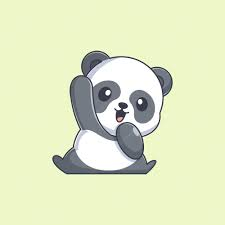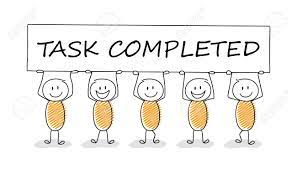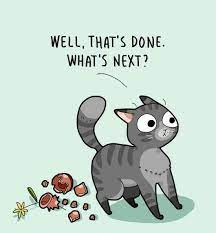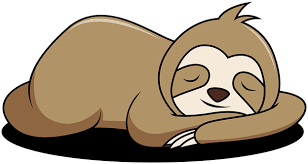